In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy
from scipy.stats import binom as binomial
from scipy.stats import beta as betafunction
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import PTMCMCSampler
from PTMCMCSampler import PTMCMCSampler as ptmcmc
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels


In [2]:
#Draw veff from prior:
def veffprop(x,iter,beta):
    q = x.copy()
    qxy = 0.
    
    q[6] = np.random.normal(0.75,0.01)
    qxy = scipy.stats.norm.pdf(q[6],0.75,0.1)

    if iter>40000:
        qxy = 1.
        q = x.copy()
    return q, qxy

class LikelihoodWrapper(object):   #Necessary because I want to use the iteration number to set proposals.
    """Wrapper for likelihood function.
        
        :param likelihood: Likelihood function that reads in parameter vector x and iteration
        """
            
    def __init__(self, likelihood):
        self.likelihood = likelihood
        self.iter = 0
    
    def __call__(self, x):
        ret = self.likelihood(x, self.iter)
        self.iter += 1
        return ret



    

In [15]:
#Real data, read in with Pandas. (Most of this data is not public and so not included in repository. Sorry.)
vobs_pandas = pd.read_csv('../Data/Xvax.csv')                #People who reported vaccination
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')             #Number of people surveyed about vacc.
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')            #positive serology tests
strials_pandas = pd.read_csv('../Data/NseroNew.csv')         #all serology tests
cases_pandas = pd.read_csv('../Data/reported_cases_all.csv') #There are lab-confirmed and suspected cases

#Select the location you want to work with
#Full list: = ['KINSHASA','EQUATEUR','MANIEMA','ORIENTALE','BANDUNDU', 'BAS-CONGO', 'KASAI-OCCIDENTAL', 'KASAI-ORIENTAL',
#           'KATANGA', 'NORD-KIVU', 'SUD-KIVU' ]
loc_subset = ['SUDKIVU'] #We work with one province at a time in general
vobs = vobs_pandas.loc[:,loc_subset]
vtrial = vtrials_pandas.loc[:,loc_subset]
sobs = sobs_pandas.loc[:,loc_subset]
strial = strials_pandas.loc[:,loc_subset]
cases = cases_pandas.loc[:,loc_subset]

#Convert to numpy arrays
vo = vobs.values
vt = vtrial.values
so = sobs.values
st = strial.values
co = cases.values

vo = np.sum(vo,axis=-1)
vt = np.sum(vt,axis=-1)
so = np.sum(so,axis=-1)
st = np.sum(st,axis=-1)
co = np.sum(co,axis=-1)

vobs = np.copy(vo)
vtry = np.copy(vt)
sobs = np.copy(so)
stry = np.copy(st)
cobs = np.copy(co)

print np.shape(vo)

(60,)


In [16]:
#Read in and process data from simulation
'''
Data_pd = pd.read_csv("FakeData50.csv",header=None)
Data = Data_pd.as_matrix()
vo = Data[:,0].copy()
vt = Data[:,1].copy()
so = Data[:,2].copy()
st = Data[:,3].copy()
cobs = Data[:,4].copy()

vobs = vo.copy()
vtry = vt.copy()
sobs = so.copy()
stry = st.copy()
'''

'\nData_pd = pd.read_csv("FakeData50.csv",header=None)\nData = Data_pd.as_matrix()\nvo = Data[:,0].copy()\nvt = Data[:,1].copy()\nso = Data[:,2].copy()\nst = Data[:,3].copy()\ncobs = Data[:,4].copy()\n\nvobs = vo.copy()\nvtry = vt.copy()\nsobs = so.copy()\nstry = st.copy()\n'

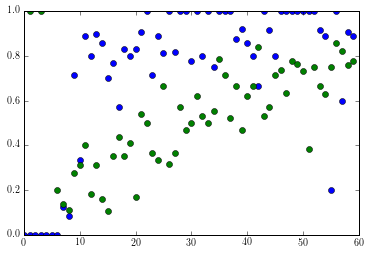

In [17]:
#Plot data to make sure it doesn't look crazy.

total_cases = np.sum(cobs[:])

plt.plot(vobs.astype(float)/vtry.astype(float),'bo')
plt.plot(sobs.astype(float)/stry.astype(float),'go')

plt.savefig('Kinshasadata.pdf')

In [34]:
#Now define the prior and likelihood:

def logltest(x,iter):  #Run with this likelihood to make sure you recover the prior. For testing new jump props.
    return 0.0

def logl(x,iter): 
    lnlike = 0.
    N = len(vobs) #Length of data
    
    #Parameters
    valpha = va = x[0]
    vbeta = vb = x[1]
    vheight = vh = x[2]
    
    falpha = fa =x[3]
    fbeta = fb = x[4]
    fheight = fh =x[5]
    
    veff = ve = x[6]

    
    vprob = np.zeros(N)
    sprob = np.zeros(N)
    cprob = np.zeros(N)
    for i in range(0,N):
        a = float(i+1.)
        vprob[i] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        sprob[i] = 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - fh*(1. - np.exp(-(a/fb)**fa)))
        cprob[i] = (1.-np.exp(-fh*(fa/fb)*(a*12./fb)**(fa-1.)*np.exp(-(a*12./fb)**fa)))*\
                                       (np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(1.-np.exp(-(a*12./fb)**fa))))
        if vprob[i] < 0.0:
            #print vprob
            return -np.inf
        if sprob[i] < 0.0:
            #print sprob
            return -np.inf
        
        lnlike += np.log(binomial.pmf(vobs[i],vtry[i],vprob[i]))
        lnlike += np.log(binomial.pmf(sobs[i],stry[i],sprob[i]))
        #lnlike += 0.
   
    cprob /= sum(cprob[:]) 
    lnlike += scipy.stats.multinomial.logpmf(cobs[:],total_cases,cprob[:])
    return lnlike



def lnprior(x):
    logp = 0.
    
    valpha = x[0]
    vbeta = x[1]
    vheight = x[2]
    falpha = x[3]
    fbeta = x[4]
    fheight = x[5]
    veff = x[6]    

    logp += np.log(gamma.pdf(valpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(vbeta,a=2.,scale=500.))
    logp += np.log(gamma.pdf(vheight,a=2.,scale=15.))
    
    logp += np.log(gamma.pdf(falpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(fbeta,a=2.,scale=500.))
    logp += np.log(gamma.pdf(fheight,a=2.,scale=15.))
    
    #logp += np.log(scipy.stats.beta.pdf(veff,a=85.,b=15.)) #Strict
    logp += np.log(scipy.stats.beta.pdf(veff,a=16.,b=5.))  #Moderate
    #logp += np.log(scipy.stats.beta.pdf(veff,a=1.,b=1.))   #Flat prior
    
    return logp



In [35]:
#Set up chain
ndim = 7

#Set up initial point
p0PT = np.random.uniform(low=0.0, high=1.0, size=(1, 1, ndim)) #Start at random point
p0PT = np.array(p0PT)
x0 = np.copy(p0PT[0,0,:])

#You can specify this point to be something specific, too.
x0[0] = 7.
x0[1] = 14.2
x0[2] = 1.645
x0[3] = 2.
x0[4] = 200.
x0[5] = 0.5
x0[6] = 0.9


In [36]:
#Test the likelihood call
logl(x0,1)


-780.81555799545436

In [38]:
#Need an initial covariance matrix for this sampler:
cov_diag = np.ones(ndim)
cov_diag *= p0PT[0,0,:]*0.5

like = LikelihoodWrapper(logl)

#Set up sampler, name the outdirectory to wherever you want to store the chains.
sampler = ptmcmc.PTSampler(int(ndim), like, lnprior, cov=np.diag(cov_diag), groups=None, 
                           outDir='./chains/', verbose=True, resume=False)
sampler.addProposalToCycle(veffprop,1)

nchains: 1


In [39]:
#Sample!
sampler.sample(p0=x0, Niter=int(15.e4), thin=20,
                covUpdate=10000, AMweight=15,
                SCAMweight=25, DEweight=50,
                writeHotChains=False)

0
Finished 6.67 percent in 159.817881 s Acceptance rate = 0.2958Adding DE jump with weight 50
Finished 54.67 percent in 1273.704233 s Acceptance rate = 0.282549

KeyboardInterrupt: 

In [19]:
#Now load in the samples and make a plot.
samples = []
i = 0
burnin = 3000
for line in open('chains/DRCLab/sero/SKIVU/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)

samples = samples.astype(float)


(699, 12)


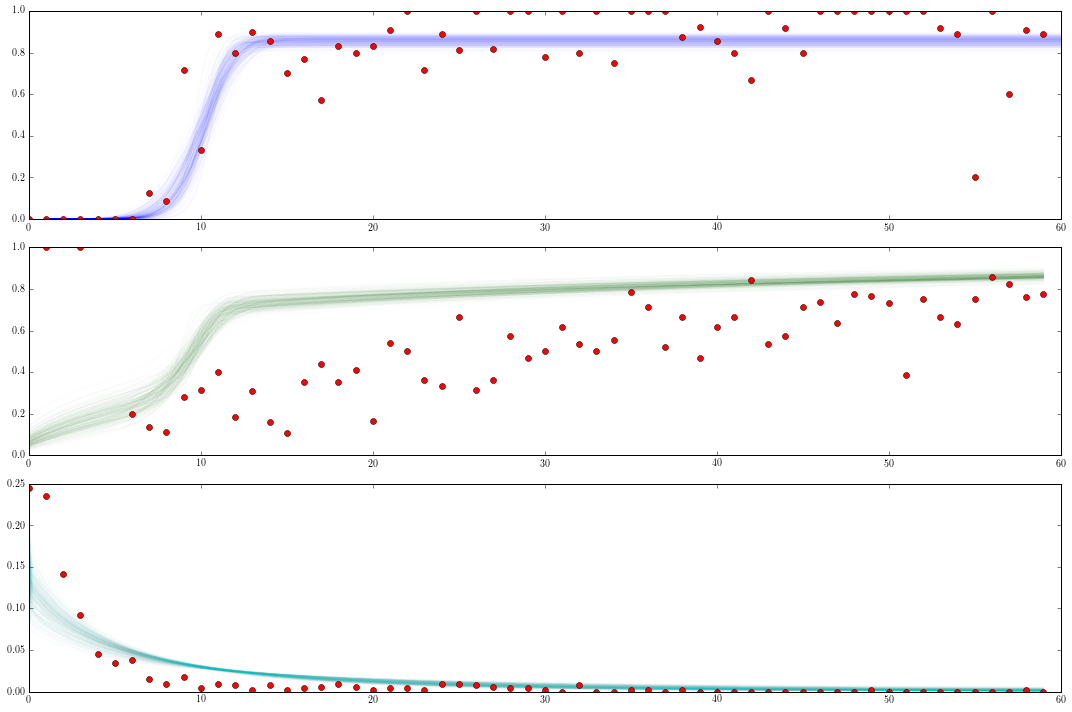

In [20]:
nspace = 500
x = np.linspace(1,60,nspace)
cplot = np.zeros(nspace)
vplot = np.zeros(nspace)
vplot2 = np.zeros(nspace)
splot = np.zeros(nspace)
ctest = np.zeros(nspace)
foi = np.zeros(nspace)
l = len(samples[:,0])
nplot = 300
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
#ax0 = axes
ax0, ax1, ax2 = axes.flatten()
#ax0, ax1 = axes.flatten()
for k in range(nplot):
    index = np.random.randint(l)
    
    valpha = samples[index,0]
    vbeta = samples[index,1]
    vheight = samples[index,2]
    falpha = samples[index,3]
    fbeta = samples[index,4]
    fheight = samples[index,5]
    veff = samples[index,6]
    
    va = valpha
    vb = vbeta
    vh = vheight
    ve = veff
    
    fa = falpha
    fb = fbeta
    fh = fheight
    
    
    j = 0
    for i in x:
        a = float(i)
        vplot[j] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        splot[j] = 1.0 - np.exp(-ve*vh*(1.-np.exp(-(i/vb)**va)) - fh*(1. - np.exp((-(i/fb)**fa))))
        cplot[j] = (1.-np.exp(-(fh*fa/fb*(a*12./fb))**(fa-1.)*np.exp(-(a*12./fb)**fa)))\
        *(np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(1.-np.exp(-(a*12./fb)**fa))))
        j += 1
    ax0.plot(x,vplot,alpha=0.01,color='b')
    ax1.plot(x-1,splot,alpha=0.01,color='g',linewidth=1)
    ax2.plot(x-1,cplot/(sum(cplot)*(x[1]-x[0])),alpha=0.01,color='c',linewidth=1)
        
ax0.plot(vobs.astype(float)/vtry.astype(float), 'ro')
ax1.plot(sobs.astype(float)/stry.astype(float),'ro')
ax2.plot(cobs.astype(float)/total_cases,'ro')

plt.xlim(0,60)
fig.tight_layout()
